# Use LSTM for Move Review Classification

Import libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
batch_size = 64

Functions for tokenization and padding

In [4]:
def tokenize(x_train, x_val):
    word_list = []

    # Get a list of all tokens
    for sent in x_train:
        words = sent.split()
        for i, word in enumerate(words): # Already lowercased and punctuation split off in dataset
            word_list.append(word)

    for i in range(1000): # Make sure unknown token is common
        word_list.append('<unk>') # Add an unknown token
    # Get corpus of all words in training data
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:5000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tokenize
    final_list_train, final_list_val = [], []
    for sent in x_train:
        sent_list = [onehot_dict[word] if word in onehot_dict.keys() else onehot_dict['<unk>'] for word in sent.split()]
        final_list_train.append(sent_list)

    for sent in x_val:
        sent_list = [onehot_dict[word] if word in onehot_dict.keys() else onehot_dict['<unk>'] for word in sent.split()]
        final_list_val.append(sent_list)

    # 0 pad to have equal length
    #max_len = max([len(i) for i in final_list_train])
    max_len = 500

    for i in range(len(final_list_train)):
        if len(final_list_train[i]) < max_len:
            final_list_train[i] = final_list_train[i] + [0] * (max_len - len(final_list_train[i]))
        elif len(final_list_train[i]) == max_len:
            continue
        else:
            final_list_train[i] = final_list_train[i][:max_len]

    for i in range(len(final_list_val)):
        if len(final_list_val[i]) < max_len:
            final_list_val[i] = final_list_val[i] + [0] * (max_len - len(final_list_val[i]))
        elif len(final_list_val[i]) == max_len:
            continue
        else:
            final_list_val[i] = final_list_val[i][:max_len]


    print(len(final_list_train[0]),len(final_list_train[1]))
    return np.array(final_list_train), np.array(final_list_val), onehot_dict

## Read in data

In [5]:
data_path = 'drive/MyDrive/UMD/MSML641/Project/Data/CornellMovieReview_scale_data'

train = pd.read_csv(f'{data_path}/MovieReviewScaleData_Train_PolarityValence.csv')
val = pd.read_csv(f'{data_path}/MovieReviewScaleData_Val_PolarityValence.csv')
test = pd.read_csv(f'{data_path}/MovieReviewScaleData_Test_PolarityValence.csv')

display(train)

,Review,Rating,ID,Class3,Class4,Author,PolarityScore,Polarity
0,carried away is an incredible film being opene...,8,5986,2,3,Steve+Rhodes,0.165410,1
1,ernest : the one-joke concept that refuses to ...,1,2240,0,0,James+Berardinelli,-0.044428,0
2,"worse still , the only thing about live and le...",5,4553,1,1,James+Berardinelli,0.016052,1
3,ron shelton appears to understand two things b...,9,5831,2,3,Scott+Renshaw,0.210099,1
4,place your foot on the accelerator . watch the...,9,2626,2,3,James+Berardinelli,0.169854,1
...,...,...,...,...,...,...,...,...
3499,it is reported to be a remake of no man of her...,4,5758,0,1,Steve+Rhodes,0.057292,0
3500,"writer and director james l . brooks , who has...",8,10297,2,3,Steve+Rhodes,0.258572,1
3501,"gosh , aren't fart jokes funny ? and if you've...",3,25495,0,0,Steve+Rhodes,0.088385,0
3502,screenplay : jim mcglynn . mpaa rating : r ( p...,7,7512,2,2,Scott+Renshaw,0.264333,1


In [6]:

for i in range(train.shape[0]):
    review = train['Review'].iloc[i]
    words = review.split('.')
    review = ' . <start>'.join(words)
    review = ''.join(['<start> '] + [review])

    if '!' in review:
        words = review.split('!')
        review = ' ! <start>'.join(words)
    if '?' in review:
        words = review.split('?')
        review = ' ? <start>'.join(words)

    train['Review'].iloc[i] = review

for i in range(val.shape[0]):
    review = val['Review'].iloc[i]
    words = review.split('.')
    review = ' . <start>'.join(words)
    review = ''.join(['<start> '] + [review])

    if '!' in review:
        words = review.split('!')
        review = ' ! <start>'.join(words)
    if '?' in review:
        words = review.split('?')
        review = ' ? <start>'.join(words)

    val['Review'].iloc[i] = review

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  val['Review'].iloc[i] = review
<ipython-input-6-a6f968306030>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Review'].iloc[i] = review
<ipython-input-6-a6f968306030>:29: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are settin

Tokenize

In [7]:
x_train, x_val, vocab = tokenize(train['Review'],val['Review'])

500 500


In [8]:
print(x_train[0])

[   2 3129  304    9   26 1795   17  131 3444 1304  223    1 2930 2176
   31   42  843  186  222  592    4    2    1   17   36  106 1160  275
   31 2207  165    7 2243  165   12   21  156 1222    5  830 4043    3
    7    1  466    5    1  178  246  161  275   14  137    4    2   54
    5   47   11    9    6 3445   17  134  598    6  165   24    4    2
   41 2010  165  572    4    2   18 4044    3  360   29  169    3   16
    9    1  165   51   13  279 1796    4    2  137    3  587   11    9
    3   19   22  100  169   50    4    2   37   36    1   87  179    8
  712  304   45  111    6  165    5  805    3   19 1020    1  165    8
 1078  304   13   35   44    6  101  177    4    2   45   49    1   51
    9    6 1926    5    1  165    7    1  746 1235    4    2    1  924
    5  165   14    1  609    9  442    4    2   33  164    9 1686    5
 1647 2083   10   24    5   33  165  512  564    4    2 1954    3    1
   77  250 2243  165    3   55 1412  107    6   87  132  174  165  165
  165 

In [9]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 5000


## Create data loaders

In [10]:
x_train.shape, train['Rating'].values.squeeze().shape

((3504, 500), (3504,))

In [11]:
authors = train['Author'].unique()
authors

array(['Steve+Rhodes', 'James+Berardinelli', 'Scott+Renshaw',
       'Dennis+Schwartz'], dtype=object)

In [12]:
train['Author'] = train['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,
                                           'Scott+Renshaw':2,'Dennis+Schwartz':3})
val['Author'] = val['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,
                                       'Scott+Renshaw':2,'Dennis+Schwartz':3})

<ipython-input-12-305822442aa5>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['Author'] = train['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,
<ipython-input-12-305822442aa5>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val['Author'] = val['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,


In [13]:
# create Tensor datasets

train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(train['Author'].values))
val_data = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(val['Author'].values))

# dataloaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)

## Create Model

In [14]:
class SentimentLSTM(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)

        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

        self.fc1 = torch.nn.Linear(hidden_dim, 10)
        self.fc2 = torch.nn.Linear(10,output_dim)
        self.relu = nn.ReLU()


    def forward(self, text):
        # text dim: [sentence length, batch size]

        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]

        hidden = self.dropout1(hidden)

        output = self.fc1(hidden)
        output = self.relu(output)
        output = self.dropout2(output)

        output = self.fc2(output)

        return output

In [30]:
torch.manual_seed(100)
model = SentimentLSTM(input_dim = len(vocab)+1,
                      embedding_dim = 128,
                      hidden_dim = 64,
                      output_dim = 4
)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## Train Model

In [31]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

n_epochs = 100

# Train the model
for epoch in tqdm(range(n_epochs)):
    correct_train = 0
    correct_val = 0
    total_train_samples = 0
    total_val_samples = 0
    epoch_loss_train = 0
    epoch_loss_val = 0

    model.train()

    # Train the model
    for text, labels in train_loader:
        text = text.T.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(text)

        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        epoch_loss_train += loss.item()

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_train += (pred == labels).sum().item()
        total_train_samples += labels.size(0)

        del text, labels, pred, loss

    train_loss.append(epoch_loss_train)
    train_accuracy = (correct_train / total_train_samples) * 100
    train_acc.append(train_accuracy)

    # Validate
    with torch.no_grad():
        model.eval()

        for text, labels in val_loader:

            text = text.T.to(device)
            labels = labels.to(device)

            pred = model(text)

            loss = criterion(pred, labels)
            epoch_loss_val += loss.item()

            # Calculate accuracy for current batch
            pred = pred.argmax(dim=1)

            correct_val += (pred == labels).sum().item()
            total_val_samples += labels.size(0)

            del text, labels, pred, loss

    val_loss.append(epoch_loss_val)
    val_accuracy = (correct_val / total_val_samples) * 100
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Accuracy: {round(train_accuracy,5)}, Validation Accuracy: {round(val_accuracy,5)}")

  1%|          | 1/100 [00:00<00:40,  2.44it/s]

Epoch 1, Train Accuracy: 31.22146, Validation Accuracy: 36.46354


  2%|▏         | 2/100 [00:00<00:34,  2.85it/s]

Epoch 2, Train Accuracy: 37.27169, Validation Accuracy: 38.96104


  3%|▎         | 3/100 [00:01<00:32,  2.97it/s]

Epoch 3, Train Accuracy: 39.46918, Validation Accuracy: 42.85714


  4%|▍         | 4/100 [00:01<00:32,  2.92it/s]

Epoch 4, Train Accuracy: 43.26484, Validation Accuracy: 56.24376


  5%|▌         | 5/100 [00:01<00:32,  2.92it/s]

Epoch 5, Train Accuracy: 57.73402, Validation Accuracy: 65.63437


  6%|▌         | 6/100 [00:02<00:32,  2.88it/s]

Epoch 6, Train Accuracy: 63.41324, Validation Accuracy: 68.13187


  7%|▋         | 7/100 [00:02<00:32,  2.88it/s]

Epoch 7, Train Accuracy: 66.58105, Validation Accuracy: 68.53147


  8%|▊         | 8/100 [00:02<00:31,  2.88it/s]

Epoch 8, Train Accuracy: 69.94863, Validation Accuracy: 68.73127


  9%|▉         | 9/100 [00:03<00:31,  2.89it/s]

Epoch 9, Train Accuracy: 69.69178, Validation Accuracy: 69.23077


 10%|█         | 10/100 [00:03<00:31,  2.89it/s]

Epoch 10, Train Accuracy: 72.74543, Validation Accuracy: 71.22877


 11%|█         | 11/100 [00:03<00:31,  2.84it/s]

Epoch 11, Train Accuracy: 68.43607, Validation Accuracy: 68.73127


 12%|█▏        | 12/100 [00:04<00:30,  2.86it/s]

Epoch 12, Train Accuracy: 74.02968, Validation Accuracy: 68.83117


 13%|█▎        | 13/100 [00:04<00:29,  2.95it/s]

Epoch 13, Train Accuracy: 76.94064, Validation Accuracy: 69.53047


 14%|█▍        | 14/100 [00:04<00:28,  3.00it/s]

Epoch 14, Train Accuracy: 76.96918, Validation Accuracy: 71.82817


 15%|█▌        | 15/100 [00:05<00:27,  3.06it/s]

Epoch 15, Train Accuracy: 80.19406, Validation Accuracy: 75.02498


 16%|█▌        | 16/100 [00:05<00:26,  3.12it/s]

Epoch 16, Train Accuracy: 82.50571, Validation Accuracy: 75.72428


 17%|█▋        | 17/100 [00:05<00:26,  3.15it/s]

Epoch 17, Train Accuracy: 83.47603, Validation Accuracy: 76.62338


 18%|█▊        | 18/100 [00:06<00:26,  3.14it/s]

Epoch 18, Train Accuracy: 85.87329, Validation Accuracy: 74.72527


 19%|█▉        | 19/100 [00:06<00:25,  3.16it/s]

Epoch 19, Train Accuracy: 86.15868, Validation Accuracy: 78.52148


 20%|██        | 20/100 [00:06<00:25,  3.16it/s]

Epoch 20, Train Accuracy: 88.21347, Validation Accuracy: 70.32967


 21%|██        | 21/100 [00:07<00:25,  3.15it/s]

Epoch 21, Train Accuracy: 81.05023, Validation Accuracy: 77.12288


 22%|██▏       | 22/100 [00:07<00:24,  3.16it/s]

Epoch 22, Train Accuracy: 87.24315, Validation Accuracy: 75.52448


 23%|██▎       | 23/100 [00:07<00:24,  3.16it/s]

Epoch 23, Train Accuracy: 86.4726, Validation Accuracy: 77.42258


 24%|██▍       | 24/100 [00:07<00:23,  3.17it/s]

Epoch 24, Train Accuracy: 90.18265, Validation Accuracy: 79.02098


 25%|██▌       | 25/100 [00:08<00:23,  3.19it/s]

Epoch 25, Train Accuracy: 91.15297, Validation Accuracy: 79.12088


 26%|██▌       | 26/100 [00:08<00:23,  3.20it/s]

Epoch 26, Train Accuracy: 91.75228, Validation Accuracy: 78.12188


 27%|██▋       | 27/100 [00:08<00:22,  3.20it/s]

Epoch 27, Train Accuracy: 91.72374, Validation Accuracy: 77.92208


 28%|██▊       | 28/100 [00:09<00:22,  3.18it/s]

Epoch 28, Train Accuracy: 92.18037, Validation Accuracy: 80.81918


 29%|██▉       | 29/100 [00:09<00:22,  3.18it/s]

Epoch 29, Train Accuracy: 93.35046, Validation Accuracy: 81.91808


 30%|███       | 30/100 [00:09<00:22,  3.17it/s]

Epoch 30, Train Accuracy: 94.37785, Validation Accuracy: 79.02098


 31%|███       | 31/100 [00:10<00:21,  3.17it/s]

Epoch 31, Train Accuracy: 82.30594, Validation Accuracy: 76.12388


 32%|███▏      | 32/100 [00:10<00:21,  3.18it/s]

Epoch 32, Train Accuracy: 86.87215, Validation Accuracy: 76.42358


 33%|███▎      | 33/100 [00:10<00:21,  3.18it/s]

Epoch 33, Train Accuracy: 90.23973, Validation Accuracy: 79.42058


 34%|███▍      | 34/100 [00:11<00:20,  3.16it/s]

Epoch 34, Train Accuracy: 91.55251, Validation Accuracy: 80.11988


 35%|███▌      | 35/100 [00:11<00:20,  3.16it/s]

Epoch 35, Train Accuracy: 93.29338, Validation Accuracy: 79.42058


 36%|███▌      | 36/100 [00:11<00:20,  3.17it/s]

Epoch 36, Train Accuracy: 93.09361, Validation Accuracy: 82.41758


 37%|███▋      | 37/100 [00:12<00:19,  3.15it/s]

Epoch 37, Train Accuracy: 94.32078, Validation Accuracy: 82.11788


 38%|███▊      | 38/100 [00:12<00:19,  3.17it/s]

Epoch 38, Train Accuracy: 93.89269, Validation Accuracy: 78.92108


 39%|███▉      | 39/100 [00:12<00:19,  3.17it/s]

Epoch 39, Train Accuracy: 92.63699, Validation Accuracy: 80.61938


 40%|████      | 40/100 [00:12<00:18,  3.18it/s]

Epoch 40, Train Accuracy: 94.69178, Validation Accuracy: 82.01798


 41%|████      | 41/100 [00:13<00:18,  3.16it/s]

Epoch 41, Train Accuracy: 95.26256, Validation Accuracy: 84.11588


 42%|████▏     | 42/100 [00:13<00:18,  3.17it/s]

Epoch 42, Train Accuracy: 96.94635, Validation Accuracy: 83.61638


 43%|████▎     | 43/100 [00:13<00:17,  3.18it/s]

Epoch 43, Train Accuracy: 96.26142, Validation Accuracy: 82.81718


 44%|████▍     | 44/100 [00:14<00:18,  3.07it/s]

Epoch 44, Train Accuracy: 96.48973, Validation Accuracy: 82.81718


 45%|████▌     | 45/100 [00:14<00:18,  3.02it/s]

Epoch 45, Train Accuracy: 87.55708, Validation Accuracy: 77.12288


 46%|████▌     | 46/100 [00:14<00:18,  2.97it/s]

Epoch 46, Train Accuracy: 93.57877, Validation Accuracy: 79.32068


 47%|████▋     | 47/100 [00:15<00:18,  2.90it/s]

Epoch 47, Train Accuracy: 95.26256, Validation Accuracy: 80.41958


 48%|████▊     | 48/100 [00:15<00:17,  2.91it/s]

Epoch 48, Train Accuracy: 96.57534, Validation Accuracy: 80.71928


 49%|████▉     | 49/100 [00:16<00:17,  2.91it/s]

Epoch 49, Train Accuracy: 96.57534, Validation Accuracy: 81.81818


 50%|█████     | 50/100 [00:16<00:17,  2.88it/s]

Epoch 50, Train Accuracy: 97.37443, Validation Accuracy: 83.81618


 51%|█████     | 51/100 [00:16<00:17,  2.86it/s]

Epoch 51, Train Accuracy: 96.94635, Validation Accuracy: 82.21778


 52%|█████▏    | 52/100 [00:17<00:16,  2.84it/s]

Epoch 52, Train Accuracy: 97.40297, Validation Accuracy: 83.51648


 53%|█████▎    | 53/100 [00:17<00:16,  2.93it/s]

Epoch 53, Train Accuracy: 97.91667, Validation Accuracy: 83.21678


 54%|█████▍    | 54/100 [00:17<00:15,  3.00it/s]

Epoch 54, Train Accuracy: 97.54566, Validation Accuracy: 81.31868


 55%|█████▌    | 55/100 [00:18<00:14,  3.05it/s]

Epoch 55, Train Accuracy: 97.48858, Validation Accuracy: 81.91808


 56%|█████▌    | 56/100 [00:18<00:14,  3.08it/s]

Epoch 56, Train Accuracy: 97.31735, Validation Accuracy: 83.11688


 57%|█████▋    | 57/100 [00:18<00:13,  3.11it/s]

Epoch 57, Train Accuracy: 97.11758, Validation Accuracy: 80.51948


 58%|█████▊    | 58/100 [00:19<00:13,  3.12it/s]

Epoch 58, Train Accuracy: 97.11758, Validation Accuracy: 82.21778


 59%|█████▉    | 59/100 [00:19<00:13,  3.14it/s]

Epoch 59, Train Accuracy: 97.43151, Validation Accuracy: 82.61738


 60%|██████    | 60/100 [00:19<00:12,  3.14it/s]

Epoch 60, Train Accuracy: 97.83105, Validation Accuracy: 83.81618


 61%|██████    | 61/100 [00:20<00:14,  2.64it/s]

Epoch 61, Train Accuracy: 97.97374, Validation Accuracy: 83.91608


 62%|██████▏   | 62/100 [00:20<00:14,  2.59it/s]

Epoch 62, Train Accuracy: 97.91667, Validation Accuracy: 83.01698


 63%|██████▎   | 63/100 [00:20<00:13,  2.74it/s]

Epoch 63, Train Accuracy: 98.25913, Validation Accuracy: 82.41758


 64%|██████▍   | 64/100 [00:21<00:12,  2.84it/s]

Epoch 64, Train Accuracy: 97.80251, Validation Accuracy: 82.51748


 65%|██████▌   | 65/100 [00:21<00:12,  2.91it/s]

Epoch 65, Train Accuracy: 96.74658, Validation Accuracy: 81.51848


 66%|██████▌   | 66/100 [00:21<00:11,  2.98it/s]

Epoch 66, Train Accuracy: 97.60274, Validation Accuracy: 82.81718


 67%|██████▋   | 67/100 [00:22<00:10,  3.04it/s]

Epoch 67, Train Accuracy: 97.74543, Validation Accuracy: 83.81618


 68%|██████▊   | 68/100 [00:22<00:10,  3.06it/s]

Epoch 68, Train Accuracy: 97.74543, Validation Accuracy: 83.21678


 69%|██████▉   | 69/100 [00:22<00:09,  3.11it/s]

Epoch 69, Train Accuracy: 97.23174, Validation Accuracy: 84.31568


 70%|███████   | 70/100 [00:23<00:09,  3.13it/s]

Epoch 70, Train Accuracy: 97.2032, Validation Accuracy: 80.01998


 71%|███████   | 71/100 [00:23<00:09,  3.13it/s]

Epoch 71, Train Accuracy: 97.77397, Validation Accuracy: 81.91808


 72%|███████▏  | 72/100 [00:23<00:08,  3.14it/s]

Epoch 72, Train Accuracy: 97.97374, Validation Accuracy: 83.21678


 73%|███████▎  | 73/100 [00:24<00:08,  3.15it/s]

Epoch 73, Train Accuracy: 97.80251, Validation Accuracy: 83.71628


 74%|███████▍  | 74/100 [00:24<00:08,  3.15it/s]

Epoch 74, Train Accuracy: 98.17352, Validation Accuracy: 84.11588


 75%|███████▌  | 75/100 [00:24<00:07,  3.13it/s]

Epoch 75, Train Accuracy: 96.94635, Validation Accuracy: 81.51848


 76%|███████▌  | 76/100 [00:25<00:07,  3.13it/s]

Epoch 76, Train Accuracy: 97.11758, Validation Accuracy: 80.21978


 77%|███████▋  | 77/100 [00:25<00:07,  3.14it/s]

Epoch 77, Train Accuracy: 97.71689, Validation Accuracy: 82.91708


 78%|███████▊  | 78/100 [00:25<00:07,  3.14it/s]

Epoch 78, Train Accuracy: 97.88813, Validation Accuracy: 84.81518


 79%|███████▉  | 79/100 [00:25<00:06,  3.14it/s]

Epoch 79, Train Accuracy: 98.14498, Validation Accuracy: 84.01598


 80%|████████  | 80/100 [00:26<00:06,  3.14it/s]

Epoch 80, Train Accuracy: 98.00228, Validation Accuracy: 83.41658


 81%|████████  | 81/100 [00:26<00:06,  3.12it/s]

Epoch 81, Train Accuracy: 97.77397, Validation Accuracy: 81.81818


 82%|████████▏ | 82/100 [00:26<00:05,  3.13it/s]

Epoch 82, Train Accuracy: 97.5742, Validation Accuracy: 83.81618


 83%|████████▎ | 83/100 [00:27<00:05,  3.07it/s]

Epoch 83, Train Accuracy: 97.5742, Validation Accuracy: 84.71528


 84%|████████▍ | 84/100 [00:27<00:05,  3.00it/s]

Epoch 84, Train Accuracy: 97.85959, Validation Accuracy: 85.11489


 85%|████████▌ | 85/100 [00:27<00:05,  2.97it/s]

Epoch 85, Train Accuracy: 97.71689, Validation Accuracy: 85.61439


 86%|████████▌ | 86/100 [00:28<00:04,  2.89it/s]

Epoch 86, Train Accuracy: 98.34475, Validation Accuracy: 85.71429


 87%|████████▋ | 87/100 [00:28<00:04,  2.87it/s]

Epoch 87, Train Accuracy: 98.05936, Validation Accuracy: 85.01499


 88%|████████▊ | 88/100 [00:29<00:04,  2.88it/s]

Epoch 88, Train Accuracy: 96.20434, Validation Accuracy: 80.81918


 89%|████████▉ | 89/100 [00:29<00:03,  2.89it/s]

Epoch 89, Train Accuracy: 97.46005, Validation Accuracy: 82.71728


 90%|█████████ | 90/100 [00:29<00:03,  2.85it/s]

Epoch 90, Train Accuracy: 98.20205, Validation Accuracy: 82.61738


 91%|█████████ | 91/100 [00:30<00:03,  2.81it/s]

Epoch 91, Train Accuracy: 98.11644, Validation Accuracy: 82.51748


 92%|█████████▏| 92/100 [00:30<00:02,  2.90it/s]

Epoch 92, Train Accuracy: 98.00228, Validation Accuracy: 83.31668


 93%|█████████▎| 93/100 [00:30<00:02,  2.95it/s]

Epoch 93, Train Accuracy: 97.85959, Validation Accuracy: 80.61938


 94%|█████████▍| 94/100 [00:31<00:02,  2.98it/s]

Epoch 94, Train Accuracy: 96.63242, Validation Accuracy: 83.31668


 95%|█████████▌| 95/100 [00:31<00:01,  3.03it/s]

Epoch 95, Train Accuracy: 97.74543, Validation Accuracy: 82.91708


 96%|█████████▌| 96/100 [00:31<00:01,  3.04it/s]

Epoch 96, Train Accuracy: 98.17352, Validation Accuracy: 84.61538


 97%|█████████▋| 97/100 [00:32<00:00,  3.06it/s]

Epoch 97, Train Accuracy: 96.34703, Validation Accuracy: 82.01798


 98%|█████████▊| 98/100 [00:32<00:00,  3.08it/s]

Epoch 98, Train Accuracy: 97.37443, Validation Accuracy: 83.21678


 99%|█████████▉| 99/100 [00:32<00:00,  3.09it/s]

Epoch 99, Train Accuracy: 97.26027, Validation Accuracy: 81.51848


100%|██████████| 100/100 [00:32<00:00,  3.03it/s]

Epoch 100, Train Accuracy: 97.17466, Validation Accuracy: 82.41758


## Plot results

Loss

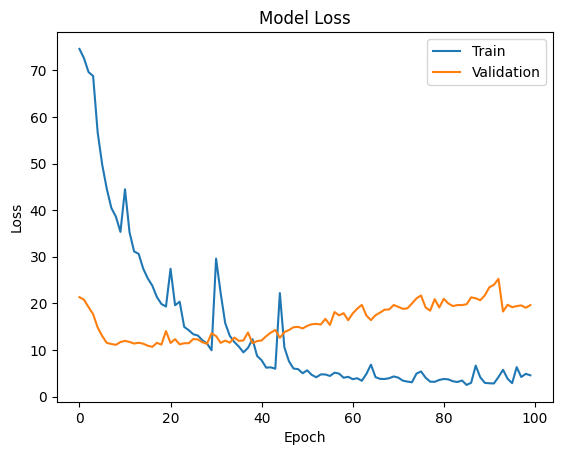

In [32]:
plt.title('Model Loss')
plt.plot([i for i in range(n_epochs)], train_loss,label='Train')
plt.plot([i for i in range(n_epochs)], val_loss,label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.close()

Accuracy

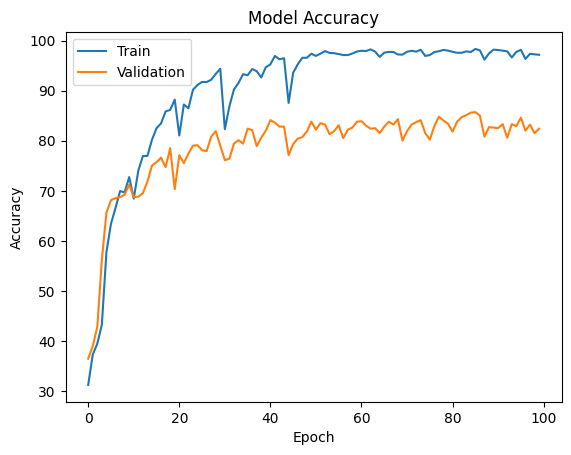

In [33]:
plt.title('Model Accuracy')
plt.plot([i for i in range(n_epochs)], train_acc, label='Train')
plt.plot([i for i in range(n_epochs)], val_acc, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.close()

Get Train Predictions

In [34]:
# Validate
with torch.no_grad():
    model.eval()

    i=0
    for text, labels in train_loader:

        text = text.T.to(device)
        labels = labels.to(device)

        pred = model(text)

        loss = criterion(pred, labels)
        val_loss.append(loss.item())

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_val += (pred == labels).sum().item()
        total_val_samples += labels.size(0)

        if i == 0:
            all_pred = pred.cpu().detach().numpy()
            all_labels = labels.cpu().detach().numpy()
            i+=1
        else:
            all_pred = np.concatenate([all_pred,pred.cpu().detach().numpy()])
            all_labels = np.concatenate([all_labels,labels.cpu().detach().numpy()])

        del text, labels, pred, loss

val_accuracy = (correct_val / total_val_samples) * 100
print(f"Final validation accuracy:", val_accuracy)

Final validation accuracy: 96.0266370699223


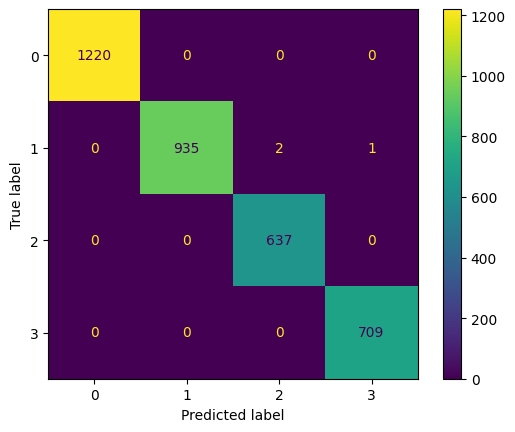

In [35]:
cm = confusion_matrix(all_labels, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Get Validation Predictions

In [36]:
# Validate
with torch.no_grad():
    model.eval()

    i=0
    for text, labels in val_loader:

        text = text.T.to(device)
        labels = labels.to(device)

        pred = model(text)

        loss = criterion(pred, labels)
        val_loss.append(loss.item())

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_val += (pred == labels).sum().item()
        total_val_samples += labels.size(0)

        if i == 0:
            all_pred = pred.cpu().detach().numpy()
            all_labels = labels.cpu().detach().numpy()
            i+=1
        else:
            all_pred = np.concatenate([all_pred,pred.cpu().detach().numpy()])
            all_labels = np.concatenate([all_labels,labels.cpu().detach().numpy()])

        del text, labels, pred, loss

val_accuracy = (correct_val / total_val_samples) * 100
print(f"Final validation accuracy:", val_accuracy)

Final validation accuracy: 93.55248819469669


Confusion Matrix

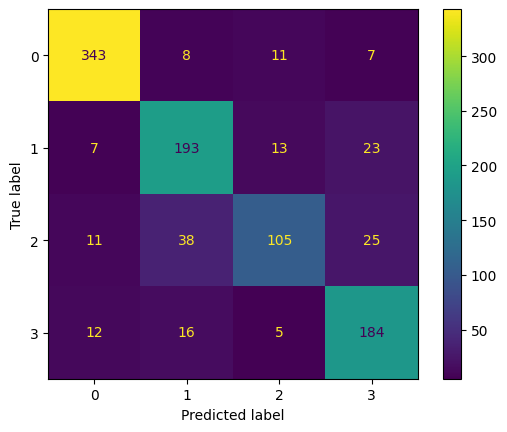

In [37]:
cm = confusion_matrix(all_labels, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [38]:
f1 = f1_score(all_labels, all_pred, average = 'weighted')
print(f"F1 score: {f1}")

F1 score: 0.8210800852020416


## Get final test accuracy

In [39]:
test['Author'] = test['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,
                                         'Scott+Renshaw':2,'Dennis+Schwartz':3})

for i in range(test.shape[0]):
    review = test['Review'].iloc[i]
    words = review.split('.')
    review = ' . <start>'.join(words)
    review = ''.join(['<start> '] + [review])

    if '!' in review:
        words = review.split('!')
        review = ' ! <start>'.join(words)
    if '?' in review:
        words = review.split('?')
        review = ' ? <start>'.join(words)

    test['Review'].iloc[i] = review

x_train, x_test, vocab = tokenize(train['Review'],test['Review'])


<ipython-input-39-24b352e6e410>:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test['Review'].iloc[i] = review
<ipython-input-39-24b352e6e410>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


500 500


In [40]:
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(test['Author'].values))
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [41]:
# Validate
test_loss = []
correct_test = 0
total_test_samples = 0
with torch.no_grad():
    model.eval()

    i=0
    for text, labels in test_loader:

        text = text.T.to(device)
        labels = labels.to(device)

        pred = model(text)

        loss = criterion(pred, labels)
        test_loss.append(loss.item())

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_test += (pred == labels).sum().item()
        total_test_samples += labels.size(0)

        if i == 0:
            all_pred = pred.cpu().detach().numpy()
            all_labels = labels.cpu().detach().numpy()
            i+=1
        else:
            all_pred = np.concatenate([all_pred,pred.cpu().detach().numpy()])
            all_labels = np.concatenate([all_labels,labels.cpu().detach().numpy()])

        del text, labels, pred, loss

test_accuracy = (correct_test / total_test_samples) * 100
print(f"Final test accuracy:", test_accuracy)

Final test accuracy: 79.84031936127745


Test Confusion Matrix

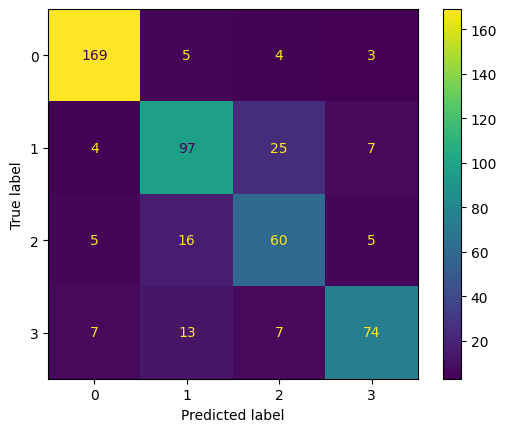

In [42]:
cm = confusion_matrix(all_labels, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Test f1 score

In [43]:
f1_score(all_labels, all_pred,average='weighted')

0.7989318061140765